In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import ast
import pickle
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
movies = pd.DataFrame(pickle.load(open('movies.pkl', 'rb')))
movies.iloc[5053].actors

['Beena Banerjee',
 'Saahil Chadha',
 'Huma Khan',
 'Javed Khan',
 'Javed Khan',
 'Baby Pooja',
 'Santosh Raut',
 'Gautam Sarin',
 'Om Shivpuri',
 '']

In [2]:
bollywood = pd.concat([pd.read_csv('indian movie database/1950-1989/bollywood_1950-1989.csv'),pd.read_csv('indian movie database/1990-2009/bollywood_1990-2009.csv'),pd.read_csv('indian movie database/2010-2019/bollywood_2010-2019.csv')])
bollywood_meta = pd.concat([pd.read_csv('indian movie database/1950-1989/bollywood_meta_1950-1989.csv'),pd.read_csv('indian movie database/1990-2009/bollywood_meta_1990-2009.csv'),pd.read_csv('indian movie database/2010-2019/bollywood_meta_2010-2019.csv')])
bollywood_ratings = pd.concat([pd.read_csv('indian movie database/1950-1989/bollywood_ratings_1950-1989.csv'),pd.read_csv('indian movie database/1990-2009/bollywood_ratings_1990-2009.csv'),pd.read_csv('indian movie database/2010-2019/bollywood_ratings_2010-2019.csv')])
bollywood_text = pd.concat([pd.read_csv('indian movie database/1950-1989/bollywood_text_1950-1989.csv'),pd.read_csv('indian movie database/1990-2009/bollywood_text_1990-2009.csv'),pd.read_csv('indian movie database/2010-2019/bollywood_text_2010-2019.csv')])
print(bollywood.shape,bollywood_meta.shape,bollywood_ratings.shape,bollywood_text.shape)

(4792, 4) (4623, 7) (4352, 3) (4578, 7)


In [3]:
movies = pd.merge(bollywood,bollywood_meta,how='outer',on=['imdb_id','title'])
movies = pd.merge(movies,bollywood_ratings,how='outer',on='imdb_id')
movies = pd.merge(movies,bollywood_text,how='outer',on='imdb_id')
movies.shape

(6978, 17)

In [4]:
movies.drop_duplicates(inplace=True,ignore_index=True)
print(movies.shape)
movies.head()

(6653, 17)


,title,imdb_id,poster_path,wiki_link,original_title,is_adult,year_of_release,runtime,genres,imdb_rating,imdb_votes,story,summary,tagline,actors,wins_nominations,release_date
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,Aag Ka Gola,0.0,1990,180,Action|Drama,5.4,81.0,Poverty and hunger forces young Shankar to tak...,Poverty and hunger forces young Shankar to tak...,NaN,Sunny Deol|Dimple Kapadia|Archana Puran Singh|...,NaN,NaN
1,Ram Lakhan,tt0098168,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Ram_Lakhan,Ram Lakhan,0.0,1989,174,Action|Drama|Musical,6.8,1993.0,Sharda (Raakhee) vows vengeance when her husba...,Sharda (Raakhee) vows vengeance when her husba...,NaN,Rakhee Gulzar|Jackie Shroff|Anil Kapoor|Dimple...,2 wins & 4 nominations,27 January 1989 (India)
2,Asmaan Se Ooncha,tt0233146,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,Asmaan Se Ooncha,0.0,1989,\N,Action|Drama|Family,5.0,44.0,Anita lives an abusive life-style with her alc...,Anita lives an abusive life-style with her alc...,NaN,Jeetendra|Raj Babbar|Anita Raj|Govinda|Sonam|S...,NaN,NaN
3,Tridev,tt0100816,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Tridev,Tridev,0.0,1989,173,Action|Crime|Drama,6.3,1602.0,Honest diligent and brave Police Inspector Ka...,A honest but disgraced Police Inspector's atte...,A Volcanic Saga of Three Angry Men,Naseeruddin Shah|Sunny Deol|Jackie Shroff|Madh...,2 wins & 2 nominations,7 July 1989 (India)
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,NaN,NaN,NaN,NaN,NaN,6.7,1298.0,Anju and Manju identical twins separated at b...,Twins separated at infancy are brought up diff...,NaN,Sridevi|Sunny Deol|Rajinikanth|Anupam Kher|Sha...,2 wins,8 December 1989 (India)


In [5]:
movies=movies.replace(r'\N',np.nan)

In [6]:
movies.isnull().sum()

title                  8
imdb_id              158
poster_path         2901
wiki_link           1863
original_title      2052
is_adult            2052
year_of_release     2054
runtime             3183
genres              2107
imdb_rating          561
imdb_votes           561
story                844
summary              184
tagline             5646
actors               212
wins_nominations    4672
release_date        2270
dtype: int64

In [7]:
movies=movies[movies['title'].notna()]
movies.isnull().sum()

title                  0
imdb_id              158
poster_path         2893
wiki_link           1855
original_title      2044
is_adult            2044
year_of_release     2046
runtime             3175
genres              2099
imdb_rating          553
imdb_votes           553
story                844
summary              184
tagline             5640
actors               212
wins_nominations    4666
release_date        2270
dtype: int64

In [8]:
movies['poster_path']=movies['poster_path'].replace(np.nan,'https://upload.wikimedia.org/wikipedia/en/2/2a/404error')
movies['poster_path']=movies['poster_path'].replace('N/A','https://upload.wikimedia.org/wikipedia/en/2/2a/404error')
movies['is_adult']=movies['is_adult'].apply(lambda x:False)
movies.head()

,title,imdb_id,poster_path,wiki_link,original_title,is_adult,year_of_release,runtime,genres,imdb_rating,imdb_votes,story,summary,tagline,actors,wins_nominations,release_date
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,Aag Ka Gola,False,1990,180,Action|Drama,5.4,81.0,Poverty and hunger forces young Shankar to tak...,Poverty and hunger forces young Shankar to tak...,NaN,Sunny Deol|Dimple Kapadia|Archana Puran Singh|...,NaN,NaN
1,Ram Lakhan,tt0098168,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Ram_Lakhan,Ram Lakhan,False,1989,174,Action|Drama|Musical,6.8,1993.0,Sharda (Raakhee) vows vengeance when her husba...,Sharda (Raakhee) vows vengeance when her husba...,NaN,Rakhee Gulzar|Jackie Shroff|Anil Kapoor|Dimple...,2 wins & 4 nominations,27 January 1989 (India)
2,Asmaan Se Ooncha,tt0233146,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,Asmaan Se Ooncha,False,1989,NaN,Action|Drama|Family,5.0,44.0,Anita lives an abusive life-style with her alc...,Anita lives an abusive life-style with her alc...,NaN,Jeetendra|Raj Babbar|Anita Raj|Govinda|Sonam|S...,NaN,NaN
3,Tridev,tt0100816,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Tridev,Tridev,False,1989,173,Action|Crime|Drama,6.3,1602.0,Honest diligent and brave Police Inspector Ka...,A honest but disgraced Police Inspector's atte...,A Volcanic Saga of Three Angry Men,Naseeruddin Shah|Sunny Deol|Jackie Shroff|Madh...,2 wins & 2 nominations,7 July 1989 (India)
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,NaN,False,NaN,NaN,NaN,6.7,1298.0,Anju and Manju identical twins separated at b...,Twins separated at infancy are brought up diff...,NaN,Sridevi|Sunny Deol|Rajinikanth|Anupam Kher|Sha...,2 wins,8 December 1989 (India)


In [9]:
def get_response(i):
    title=movies.iloc[i].title.replace('#','%23')
    if(title.find('(') != -1):
        title=title[0:title.find('(')]
    url=f"https://api.themoviedb.org/3/search/movie?api_key=77eafb7a2d8d0876433444356f90b9d7&include_adult=true&query={title}"
    if(movies.iloc[i].year_of_release == movies.iloc[i].year_of_release):
        url=url+f"&year={movies.iloc[i].year_of_release}"
    response=requests.get(url)
#     print(url)
    data=response.json()
#     print(title)
    for movie in data['results']:
        if(movie['title'] == title):
            if(movie["poster_path"] != 'null'):
                movies.loc[i,'poster_path']=f'https://image.tmdb.org/t/p/original{movie["poster_path"]}'
            if(movie['adult'] != 'null'):
                movies.loc[i,'is_adult']=float(movie['adult'])
            break

In [11]:
import time
for i in range(6270,movies.shape[0]):
    try:
        get_response(i)
    except:
        print(i)
        time.sleep(5)

In [19]:
index=0
for i in movies.index:
    if(movies.iloc[i].poster_path.startswith('https://image.tmdb.')):
        index=i
print(index)
# print(len([movies.iloc[i].title for i in movies.index if "(" in movies.iloc[i]['title']]))
# print([movies.iloc[i] for i in movies.index if "film)" not in movies.iloc[i]['title'] and "(" in movies.iloc[i]['title']])
# movies=movies[movies['imdb_id'].notna()]
# movies.isnull().sum()
# movies.head()
# movies=movies.reset_index(drop=True)
# print(len([movies.iloc[i].title for i in movies.index if "(" in movies.iloc[i].title]))
# print(len([movies.iloc[i] for i in movies.index if "film)" in movies.iloc[i].title and "(" in movies.iloc[i].title]))
# print([(movies.iloc[i].title,movies.iloc[i].year_of_release) for i in movies.index if "film)" not in movies.iloc[i].title and "(" in movies.iloc[i].title])

6486


In [ ]:
# movies['poster_path']=movies['poster_path'].replace(np.nan,'https://upload.wikimedia.org/wikipedia/en/2/2a/404error')
# movies['poster_path']=movies['poster_path'].replace('N/A','https://upload.wikimedia.org/wikipedia/en/2/2a/404error')
# import requests
# for i in movies.index:
# #     url=f'https://www.omdbapi.com/?t={movies.iloc[i].title}&apikey=5362ca82'
#     url=f'https://api.themoviedb.org/3/search/movie?api_key=77eafb7a2d8d0876433444356f90b9d7&query={movies.iloc[i].title}'
#     response=requests.get(movies.iloc[i].poster_path)
#     if(response.status_code != 200):
#         response=requests.get(url)
#         data=response.json()
#         if(len(data['results'])):
#             movies.loc[i,'poster_path']=f'https://image.tmdb.org/t/p/original/{data["results"][0]["poster_path"]}'

In [7]:
crew=pd.read_csv('indian movie database/1950-2019/bollywood_crew_1950-2019.csv')
crew.head()

,imdb_id,directors,writers
0,tt0042184,nm0025608,nm0025608|nm0324690
1,tt0042207,nm0490178,nm0161032|nm1879927
2,tt0042225,nm0707533,\N
3,tt0042233,nm0788880,nm0592578|nm0788880
4,tt0042380,nm0439074,nm1278450|nm0438022|nm1301772


In [13]:
writer=pd.read_csv('indian movie database/1950-2019/bollywood_writers_data_1950-2019.csv')
for i in crew.index:
    if(crew.iloc[i].writers == crew.iloc[i].writers):
        writers=crew.iloc[i].writers.split('|')
        writers_name=[]
        for writers_id in writers:
            for j in writer.index:
                if(writers_id == writer.iloc[j].crew_id):
                    writers_name.append(writer['name'][j])
                    break
        if(len(writers_name)):
            crew.loc[i,'writers'] = "|".join(writers_name)
        else:
            crew.loc[i,'writers'] = ''
    else:
        crew.loc[i,'writers'] = ''
crew.head()

,imdb_id,directors,writers
0,tt0042184,nm0025608,Chetan Anand|Nikolay Gogol
1,tt0042207,nm0490178,Ismat Chughtai|Asghar Jafri
2,tt0042225,nm0707533,
3,tt0042233,nm0788880,Akhtar Mirza|Kidar Nath Sharma
4,tt0042380,nm0439074,S.N. Banerjee|Jagdish Kanwal|S.K. Prem


In [14]:
director=pd.read_csv('indian movie database/1950-2019/bollywood_crew_data_1950-2019.csv')
for i in crew.index:
    null=True
    for j in director.index:
        if(crew.iloc[i].directors == director.iloc[j].crew_id):
            crew.loc[i,'directors'] = director['name'][j]
            null=False
            break
    if(null):
        crew.loc[i,'directors'] = ''
crew.head()

,imdb_id,directors,writers
0,tt0042184,Chetan Anand,Chetan Anand|Nikolay Gogol
1,tt0042207,Shaheed Latif,Ismat Chughtai|Asghar Jafri
2,tt0042225,G. Rakesh,
3,tt0042233,Kidar Nath Sharma,Akhtar Mirza|Kidar Nath Sharma
4,tt0042380,Abdul Rashid Kardar,S.N. Banerjee|Jagdish Kanwal|S.K. Prem


In [15]:
movies=pd.merge(movies,crew,on='imdb_id',how='left')
movies.head()

,title,imdb_id,poster_path,wiki_link,original_title,is_adult,year_of_release,runtime,genres,imdb_rating,imdb_votes,story,summary,tagline,actors,wins_nominations,release_date,directors,writers
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,Aag Ka Gola,False,1990,180,Action|Drama,5.4,81.0,Poverty and hunger forces young Shankar to tak...,Poverty and hunger forces young Shankar to tak...,NaN,Sunny Deol|Dimple Kapadia|Archana Puran Singh|...,NaN,NaN,David Dhawan,Ram Kelkar|Faiz Saleem
1,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,Aag Ka Gola,False,1990,180,Action|Drama,5.4,81.0,Poverty and hunger forces young Shankar to tak...,Poverty and hunger forces young Shankar to tak...,NaN,Sunny Deol|Dimple Kapadia|Archana Puran Singh|...,NaN,NaN,David Dhawan,Ram Kelkar|Faiz Saleem
2,Ram Lakhan,tt0098168,https://image.tmdb.org/t/p/original/s6MeyQ0mL9...,https://en.wikipedia.org/wiki/Ram_Lakhan,Ram Lakhan,0.0,1989,174,Action|Drama|Musical,6.8,1993.0,Sharda (Raakhee) vows vengeance when her husba...,Sharda (Raakhee) vows vengeance when her husba...,NaN,Rakhee Gulzar|Jackie Shroff|Anil Kapoor|Dimple...,2 wins & 4 nominations,27 January 1989 (India),Subhash Ghai,Subhash Ghai|Ram Kelkar|Anwar Khan
3,Asmaan Se Ooncha,tt0233146,https://image.tmdb.org/t/p/original/zhx8dgVHkQ...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,Asmaan Se Ooncha,0.0,1989,NaN,Action|Drama|Family,5.0,44.0,Anita lives an abusive life-style with her alc...,Anita lives an abusive life-style with her alc...,NaN,Jeetendra|Raj Babbar|Anita Raj|Govinda|Sonam|S...,NaN,NaN,Mehul Kumar,Pravin Bhatt
4,Tridev,tt0100816,https://image.tmdb.org/t/p/original/fWg3vBcpKy...,https://en.wikipedia.org/wiki/Tridev,Tridev,0.0,1989,173,Action|Crime|Drama,6.3,1602.0,Honest diligent and brave Police Inspector Ka...,A honest but disgraced Police Inspector's atte...,A Volcanic Saga of Three Angry Men,Naseeruddin Shah|Sunny Deol|Jackie Shroff|Madh...,2 wins & 2 nominations,7 July 1989 (India),Rajiv Rai,Arshad Parvez|Rajiv Rai|K.K. Singh


In [16]:
movies.isnull().sum()

title                  0
imdb_id              158
poster_path            0
wiki_link           1876
original_title      2085
is_adult               0
year_of_release     2087
runtime             3224
genres              2140
imdb_rating          554
imdb_votes           554
story                849
summary              184
tagline             5741
actors               212
wins_nominations    4697
release_date        2309
directors            169
writers              169
dtype: int64

In [28]:
# title
# imdb_id
# poster_path
# wiki_link
# is_adult
# year_of_release
# genres
# runtime
# imdb_rating
# summary
# tagline
# actors
# directors
# writers

In [17]:
movies=movies[['title','imdb_id','poster_path','wiki_link','is_adult','year_of_release','genres','runtime','imdb_rating','story','actors','directors','writers']]
movies.drop_duplicates(inplace=True,ignore_index=True)
movies.head()

,title,imdb_id,poster_path,wiki_link,is_adult,year_of_release,genres,runtime,imdb_rating,story,actors,directors,writers
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,False,1990,Action|Drama,180,5.4,Poverty and hunger forces young Shankar to tak...,Sunny Deol|Dimple Kapadia|Archana Puran Singh|...,David Dhawan,Ram Kelkar|Faiz Saleem
1,Ram Lakhan,tt0098168,https://image.tmdb.org/t/p/original/s6MeyQ0mL9...,https://en.wikipedia.org/wiki/Ram_Lakhan,0.0,1989,Action|Drama|Musical,174,6.8,Sharda (Raakhee) vows vengeance when her husba...,Rakhee Gulzar|Jackie Shroff|Anil Kapoor|Dimple...,Subhash Ghai,Subhash Ghai|Ram Kelkar|Anwar Khan
2,Asmaan Se Ooncha,tt0233146,https://image.tmdb.org/t/p/original/zhx8dgVHkQ...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,0.0,1989,Action|Drama|Family,NaN,5.0,Anita lives an abusive life-style with her alc...,Jeetendra|Raj Babbar|Anita Raj|Govinda|Sonam|S...,Mehul Kumar,Pravin Bhatt
3,Tridev,tt0100816,https://image.tmdb.org/t/p/original/fWg3vBcpKy...,https://en.wikipedia.org/wiki/Tridev,0.0,1989,Action|Crime|Drama,173,6.3,Honest diligent and brave Police Inspector Ka...,Naseeruddin Shah|Sunny Deol|Jackie Shroff|Madh...,Rajiv Rai,Arshad Parvez|Rajiv Rai|K.K. Singh
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,False,NaN,NaN,NaN,6.7,Anju and Manju identical twins separated at b...,Sridevi|Sunny Deol|Rajinikanth|Anupam Kher|Sha...,Pankaj Parashar,Rajesh Mazumdar|Kamlesh Pandey|Pankaj Parashar


In [24]:
movies['genres']=movies['genres'].replace(np.nan,'')
movies['actors']=movies['actors'].replace(np.nan,'')
movies['writers']=movies['writers'].replace(np.nan,'')
movies['genres'] = movies['genres'].apply(lambda x:x.split('|'))
movies['actors'] = movies['actors'].apply(lambda x:x.split('|'))
movies['writers'] = movies['writers'].apply(lambda x:x.split('|'))
movies.head()

AttributeError: 'list' object has no attribute 'split'

In [26]:
# movies_old = pd.DataFrame(pickle.load(open('movies.pkl', 'rb')))
# movies_old=movies_old.drop(['tags'],axis=1)
# movies=movies[pd.notnull(movies['imdb_id'])]
# movies_old=movies_old[['imdb_id','poster_path']]
# movies=movies.drop(['poster_path'],axis=1)
# movies=pd.merge(movies,movies_old,on='imdb_id',how='right')
# movies=movies.head(movies_old.shape[0])
# movies=movies.drop(['poster_path_x','poster_path_y','poster_path'],axis=1)
# movies=pd.concat([movies,movies_old],axis=1,keys=['imdb_id'])
# movies.to_clipboard(index=False)
# movies=pd.read_clipboard(sep='\t')
# movies.columns=movies.iloc[2]
# movies=pd.merge(movies,movies_old,on='imdb_id',how='left')
# movies=movies.drop(['index'],axis=1)
# movies=movies[pd.notnull(movies['imdb_id'])]
# movies.isnull().sum()
movies.iloc[0]

title                                                    Aag Ka Gola
imdb_id                                                    tt0177489
poster_path        https://upload.wikimedia.org/wikipedia/en/2/2a...
wiki_link                  https://en.wikipedia.org/wiki/Aag_Ka_Gola
is_adult                                                       False
year_of_release                                                 1990
genres                                               [Action, Drama]
runtime                                                          180
imdb_rating                                                      5.4
story              Poverty and hunger forces young Shankar to tak...
actors             [Sunny Deol, Dimple Kapadia, Archana Puran Sin...
directors                                               David Dhawan
writers                                    [Ram Kelkar, Faiz Saleem]
Name: 0, dtype: object

In [90]:
# for i in movies.index:
#     if(movies.iloc[i].directors == '')
pickle.dump(movies.to_dict(),open('movies.pkl','wb'))

In [91]:
movies['genres'] = movies['genres'].apply(lambda x:[i.replace(" ","") for i in x])
movies['actors'] = movies['actors'].apply(lambda x:[i.replace(" ","") for i in x])
movies['directors'] = movies['directors'].str.replace(" ","")
movies['writers'] = movies['writers'].apply(lambda x:[i.replace(" ","") for i in x])
movies.head()

,title,imdb_id,poster_path,wiki_link,is_adult,year_of_release,genres,runtime,imdb_rating,story,actors,directors,writers
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,False,1990.0,"[Action, Drama]",180,5.4,Poverty and hunger forces young Shankar to tak...,"[SunnyDeol, DimpleKapadia, ArchanaPuranSingh, ...",DavidDhawan,"[RamKelkar, FaizSaleem]"
1,Ram Lakhan,tt0098168,https://image.tmdb.org/t/p/original/s6MeyQ0mL9...,https://en.wikipedia.org/wiki/Ram_Lakhan,0.0,1989.0,"[Action, Drama, Musical]",174,6.8,Sharda (Raakhee) vows vengeance when her husba...,"[RakheeGulzar, JackieShroff, AnilKapoor, Dimpl...",SubhashGhai,"[SubhashGhai, RamKelkar, AnwarKhan]"
2,Asmaan Se Ooncha,tt0233146,https://image.tmdb.org/t/p/original/zhx8dgVHkQ...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,0.0,1989.0,"[Action, Drama, Family]",NaN,5.0,Anita lives an abusive life-style with her alc...,"[Jeetendra, RajBabbar, AnitaRaj, Govinda, Sona...",MehulKumar,[PravinBhatt]
3,Tridev,tt0100816,https://image.tmdb.org/t/p/original/fWg3vBcpKy...,https://en.wikipedia.org/wiki/Tridev,0.0,1989.0,"[Action, Crime, Drama]",173,6.3,Honest diligent and brave Police Inspector Ka...,"[NaseeruddinShah, SunnyDeol, JackieShroff, Mad...",RajivRai,"[ArshadParvez, RajivRai, K.K.Singh]"
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,False,NaN,[],NaN,6.7,Anju and Manju identical twins separated at b...,"[Sridevi, SunnyDeol, Rajinikanth, AnupamKher, ...",PankajParashar,"[RajeshMazumdar, KamleshPandey, PankajParashar]"


In [92]:
#string to list
movies['story']=movies['story'].replace(np.nan,'')
movies['directors']=movies['directors'].replace(np.nan,'')
movies['story']=movies['story'].apply(lambda x:x.split(" "))
movies['directors']=movies['directors'].apply(lambda x:x.split(" "))

In [93]:
movies['tags'] = movies['genres']+movies['story']+movies['actors']+movies['directors']+movies['writers']
movies.head()
# movies.drop(['keywords','genres','overview','cast','crew'],axis = 1,inplace=True)

,title,imdb_id,poster_path,wiki_link,is_adult,year_of_release,genres,runtime,imdb_rating,story,actors,directors,writers,tags
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,False,1990.0,"[Action, Drama]",180,5.4,"[Poverty, and, hunger, forces, young, Shankar,...","[SunnyDeol, DimpleKapadia, ArchanaPuranSingh, ...",[DavidDhawan],"[RamKelkar, FaizSaleem]","[Action, Drama, Poverty, and, hunger, forces, ..."
1,Ram Lakhan,tt0098168,https://image.tmdb.org/t/p/original/s6MeyQ0mL9...,https://en.wikipedia.org/wiki/Ram_Lakhan,0.0,1989.0,"[Action, Drama, Musical]",174,6.8,"[Sharda, (Raakhee), vows, vengeance, when, her...","[RakheeGulzar, JackieShroff, AnilKapoor, Dimpl...",[SubhashGhai],"[SubhashGhai, RamKelkar, AnwarKhan]","[Action, Drama, Musical, Sharda, (Raakhee), vo..."
2,Asmaan Se Ooncha,tt0233146,https://image.tmdb.org/t/p/original/zhx8dgVHkQ...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,0.0,1989.0,"[Action, Drama, Family]",NaN,5.0,"[Anita, lives, an, abusive, life-style, with, ...","[Jeetendra, RajBabbar, AnitaRaj, Govinda, Sona...",[MehulKumar],[PravinBhatt],"[Action, Drama, Family, Anita, lives, an, abus..."
3,Tridev,tt0100816,https://image.tmdb.org/t/p/original/fWg3vBcpKy...,https://en.wikipedia.org/wiki/Tridev,0.0,1989.0,"[Action, Crime, Drama]",173,6.3,"[Honest, , diligent, and, brave, Police, Inspe...","[NaseeruddinShah, SunnyDeol, JackieShroff, Mad...",[RajivRai],"[ArshadParvez, RajivRai, K.K.Singh]","[Action, Crime, Drama, Honest, , diligent, and..."
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,False,NaN,[],NaN,6.7,"[Anju, and, Manju, , identical, twins, separat...","[Sridevi, SunnyDeol, Rajinikanth, AnupamKher, ...",[PankajParashar],"[RajeshMazumdar, KamleshPandey, PankajParashar]","[, Anju, and, Manju, , identical, twins, separ..."


In [94]:
movies.isnull().sum()

title                 0
imdb_id               0
poster_path           0
wiki_link          1854
is_adult              0
year_of_release    1888
genres                0
runtime            3017
imdb_rating         395
story                 0
actors                0
directors             0
writers               0
tags                  0
dtype: int64

In [95]:
movies['tags']=movies['tags'].apply(lambda x:" ".join(x))
movies['tags']=movies['tags'].apply(lambda x:x.lower())

In [96]:
movies['tags'][0]
movies.iloc[25].writers

['JalalAgha',
 'NaqiAhmed',
 'JoyAugustine',
 'BonoDeb',
 'BhagwantDeshpande',
 'RahiMasoomReza']

In [97]:
# Function for removing ASCII characters
def _removeNonAscii(s):
    return "".join(i for i in s if ord(i)<128)

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing html
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

movies['tags'] = movies['tags'].apply(_removeNonAscii)
movies['tags'] = movies['tags'].apply(func = remove_stop_words)
movies['tags'] = movies['tags'].apply(func = remove_punctuation)
movies['tags'] = movies['tags'].apply(func = remove_html)

In [98]:
movies['tags'][0]

'action drama poverty hunger forces young shankar take employment mechanic extent well arrested police crime committed shankar manages escape witness mom die shock unable bear police arrest son shankar taken criminal raja babu teaches every criminal activity exists years later shankar known shakka works raja babu professional criminal one day shakka experiences change heart asked abducted small child results death mother turns police case tried court shakka sentenced five years imprisonment save life minister sentence reduced three years shakka released jail decides give criminal ways marry aarti buys garage earn living proud father baby boy vicky sunnydeol dimplekapadia archanapuransingh shaktikapoor premchopra omshivpuri razamurad anjanamumtaz maheshanand sharatsaxena atleebrar gurbachansingh bobchristo jagdishraj daviddhawan ramkelkar faizsaleem'

In [99]:
# Splitting the description into words
corpus = []
for words in movies['tags']:
    corpus.append(words.split())

In [100]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

EMBEDDING_FILE = 'C:/Users/user/gensim-data/word2vec-google-news-300/GoogleNews-vectors-negative300.bin'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True)

# Training our corpus with the model
google_model = Word2Vec(vector_size = 300, window = 5, min_count = 1, workers = -1)
google_model.build_vocab(corpus)
google_model.wv.vectors_lockf = np.ones(len(google_model.wv))

google_model.wv.intersect_word2vec_format(EMBEDDING_FILE, lockf = 1.0, binary = True)
google_model.train(corpus, total_examples = google_model.corpus_count, epochs = 5)

C:\Users\user/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


(0, 0)

In [101]:
from numpy.linalg import norm
def cosine_similarity(word_embedding):
    similarity=[]
    for movie1 in word_embedding:
        if(not norm(movie1)):
            similarity.append((np.ones(len(word_embedding))*-1).tolist())
        else:
            similarity.append([np.dot(x,movie1)/(norm(movie1)*norm(x)) if len(x) else -1 for x in word_embedding])
    return similarity

In [102]:
def vectors(x):
    
    # Creating a list for storing the vectors ('Description' into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each 'Description'
    for line in movies['tags']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in google_model.wv.key_to_index.keys():
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model.wv[word]
                else:
                    avgword2vec = avgword2vec + google_model.wv[word]
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            word_embeddings.append(avgword2vec)
        else:
            word_embeddings.append([])
# Calling the function vectors
vectors(movies)

# Finding cosine similarity for the vectors
cosine_similarities = cosine_similarity(word_embeddings)

In [103]:
print(len(word_embeddings),movies.shape)

6484 (6484, 14)


In [104]:
movies['poster_path']=movies['poster_path'].replace(np.nan,'')

In [105]:
# Recommending the Top 5 similar movies
def recommendations(movie):
    # Taking the Title and Movie Image Link and store in new dataframe called 'movies'
    movies_new = movies[['title', 'poster_path']]

    # Reverse mapping of the index
    indices = pd.Series(movies.index, index = movies['title']).drop_duplicates()
         
    idx = indices[movie]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    recommend = movies.iloc[movie_indices]

    for index, row in recommend.iterrows():
        if(row['poster_path'] != ''):
            response = requests.get(row['poster_path'])
    #         print(response.status_code)
            if(response.status_code != 200):
                print(row['title'])
            else:
                img = Image.open(BytesIO(response.content))
                plt.figure()
                plt.imshow(img)
                plt.title(row['title'])
        else:
            print(row['title'])

In [106]:
# Building the TF-IDF model and calculating the TF-IDF score
tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 3), min_df = 2, stop_words = 'english')
tfidf.fit(movies['tags'])

# Getting the words from the TF-IDF model
tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

# TF-IDF words/column names
tfidf_feature = tfidf.get_feature_names()


In [107]:
# Storing the TFIDF Word2Vec embeddings
tfidf_vectors = [] 
line = 0

# For each 'Description'
for desc in corpus:

    # Word vectors are of zero length (using 300 dimensions)
    sent_vec = np.zeros(300) 

    # Number of words with a valid vector in the 'Description'
    weight_sum =0; 

    # For each word in the 'Description'
    for word in desc: 
        if word in google_model.wv.key_to_index.keys() and word in tfidf_feature:
            vec = google_model.wv[word]
            tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    line += 1
# Finding cosine similarity for the vectors
cosine_similarities_2 = cosine_similarity(tfidf_vectors)

In [108]:
# cosine_similarities=cosine_similarities.tolist()
sl1 = sorted(enumerate(cosine_similarities[0]),key=lambda x:x[1],reverse=True)
sl2 = sorted(enumerate(cosine_similarities_2[0]),key=lambda x:x[1],reverse=True)
print(sl1)

[(0, 1.0), (1083, 0.9200475), (4615, 0.91383684), (4787, 0.9133447), (4616, 0.91273135), (3488, 0.9119586), (657, 0.91131026), (3489, 0.90941024), (4786, 0.90655917), (785, 0.90548867), (132, 0.9020643), (131, 0.9003221), (1050, 0.9002491), (4351, 0.8997704), (4486, 0.8986227), (5072, 0.8986078), (2203, 0.89748776), (1386, 0.89682275), (1202, 0.8960243), (4865, 0.8957749), (4820, 0.895559), (1154, 0.8950373), (1517, 0.89260906), (6257, 0.89217514), (1153, 0.8912163), (4864, 0.8909437), (1242, 0.89078575), (4579, 0.89049685), (4033, 0.8902538), (4576, 0.89002305), (6256, 0.8897395), (228, 0.8882107), (482, 0.88726825), (1489, 0.8870005), (1178, 0.88676375), (1499, 0.8865866), (4856, 0.8861364), (642, 0.88592315), (1518, 0.8856329), (4819, 0.88556385), (121, 0.88474375), (1621, 0.884543), (4085, 0.8841059), (4371, 0.8836703), (6305, 0.8831564), (4575, 0.8830949), (2314, 0.8828689), (4185, 0.8828055), (1337, 0.88256633), (4855, 0.8823649), (5727, 0.8823627), (4084, 0.8823343), (1241, 0.88

In [109]:
print(sl2)

[(0, 1.0), (4616, 0.8739772723470698), (1532, 0.8716430238994219), (1533, 0.8695589845081724), (1365, 0.8584744397851548), (3488, 0.8567335297066445), (54, 0.8556659727018955), (3489, 0.8552994988395749), (1083, 0.8539288465457369), (3207, 0.8400883756791176), (172, 0.8395241399648681), (171, 0.8386353059793721), (1386, 0.837811352483358), (707, 0.8338599487546055), (1372, 0.8337185781215192), (815, 0.828356953452237), (785, 0.8281729353428889), (477, 0.8270242740609555), (476, 0.8233299735337434), (128, 0.8223375179578876), (56, 0.8221512430721913), (408, 0.8208009241345022), (5072, 0.8195563851963477), (1202, 0.8195336345273525), (215, 0.8185888136698922), (642, 0.8177693557030765), (1050, 0.8162533376349715), (854, 0.8157076540078799), (4886, 0.8135140228221166), (3907, 0.81344619997779), (3498, 0.8132650793395618), (4971, 0.8132450785419069), (4970, 0.8128813924439329), (640, 0.8128348009143888), (3497, 0.8114933977777282), (1310, 0.8109883630539446), (407, 0.810584757170154), (506

In [110]:
# Recommending top 5 similar movies
def recommendations_2(movie):
    # Taking the Title and Image Link and store in new data frame called movies
    movies_new = movies[['title', 'poster_path']]
    
    # Reverse mapping of the index
    indices = pd.Series(movies.index, index = movies['title']).drop_duplicates()
        
    idx = indices[movie]
    sim_scores = list(enumerate(cosine_similarities_2[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    recommend = movies_new.iloc[movie_indices]
    for index, row in recommend.iterrows():
        if(row['poster_path'] != ''):
            response = requests.get(row['poster_path'])
    #         print(response.status_code)
            if(response.status_code != 200):
                print(row['title'])
            else:
                img = Image.open(BytesIO(response.content))
                plt.figure()
                plt.imshow(img)
                plt.title(row['title'])
        else:
            print(row['title'])

Aakhri Kasam
Procession of Memories


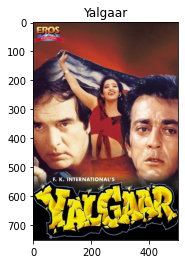

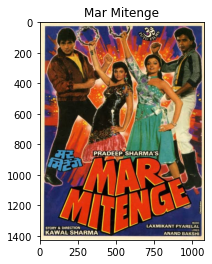

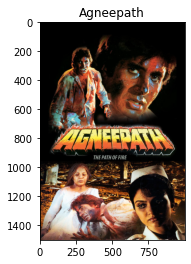

In [111]:
recommendations('Ram Lakhan')

Hungama
Hungama (1971 film)
Mera Ghar Mere Bachche
Aulad (1968 film)
Maha Chor
Aisa Kyon Hota Hai?
Sampoorna Ramayana
Madhavi
Madhavi (1969 film)


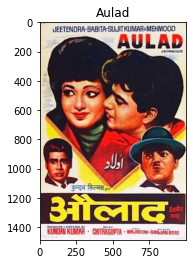

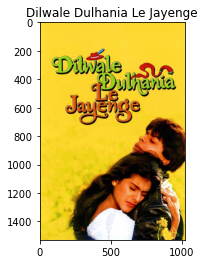

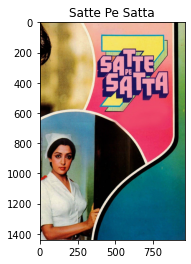

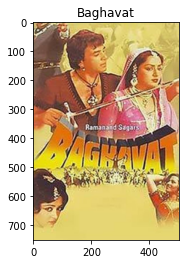

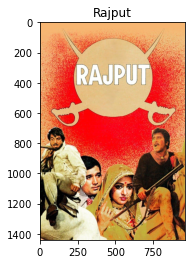

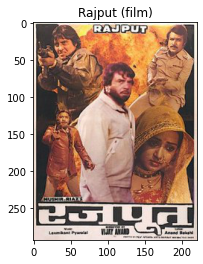

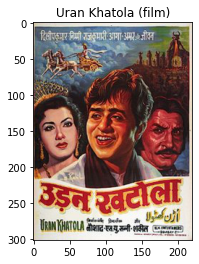

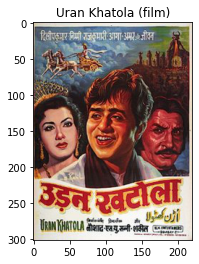

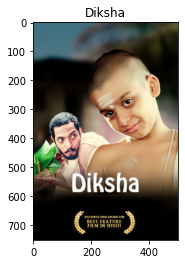

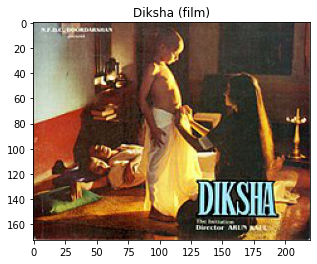

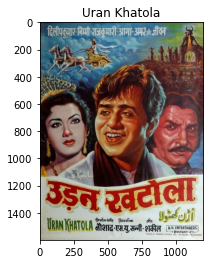

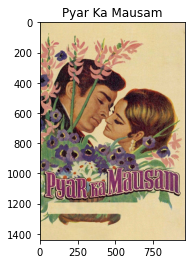

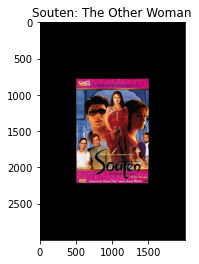

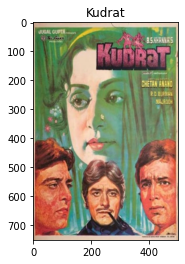

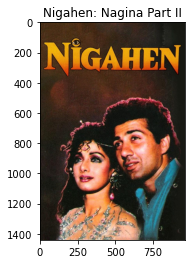

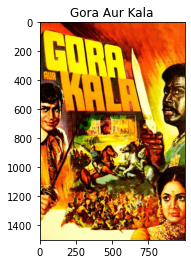

In [112]:
recommendations_2('Batwara')

In [113]:
# cosine_similarities=(np.array(cosine_similarities)+np.array(cosine_similarities_2))/2
# recommendations('Ram Lakhan')
cosine_similarities = [sorted(enumerate(x),key=lambda y:y[1],reverse=True)[:100] for x in cosine_similarities]
cosine_similarities_2 = [sorted(enumerate(x),key=lambda y:y[1],reverse=True)[:100] for x in cosine_similarities_2]

In [114]:
pickle.dump(cosine_similarities,open('similarity.pkl','wb'))
pickle.dump(cosine_similarities_2,open('similarity_2.pkl','wb'))

In [118]:
# movies.drop(['index','level_0'],axis = 1)
len(cosine_similarities)

6484